In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from shapely import Polygon,Point,MultiPoint,LineString
from scipy.spatial import ConvexHull
from itertools import combinations
from shapely.ops import unary_union
from IPython.display import display, clear_output
from matplotlib import animation
def getPotRegions(X,imp):
    Bx= np.zeros((len(X),4,2));
    for i in range(len(X)):
        Bx[i,0,:]= [X[i][0]-imp, X[i][1]+imp]
        Bx[i,1,:]= [X[i][0]+imp, X[i][1]+imp]
        Bx[i,2,:]= [X[i][0]+imp, X[i][1]-imp]
        Bx[i,3,:]= [X[i][0]-imp, X[i][1]-imp]
    return(Bx);
def getPotRegions_var(X,imp):
    Bx= np.zeros((len(X),4,2));
    for i in range(len(X)):
        Bx[i,0,:]= [X[i][0]-imp[i], X[i][1]+imp[i]]
        Bx[i,1,:]= [X[i][0]+imp[i], X[i][1]+imp[i]]
        Bx[i,2,:]= [X[i][0]+imp[i], X[i][1]-imp[i]]
        Bx[i,3,:]= [X[i][0]-imp[i], X[i][1]-imp[i]]
    return(Bx);
def CPIH_Safepoint(n,Bx,Xi):
    k = int(np.floor(2/3*n)+1);
    n = np.arange(n);

    combk = list(combinations(n,k));
    safeX = [];
    safeY =[];
    first= True;
    CPIH= Polygon();
    #testing
   
    for C in combk:
        if Xi in C:
            comb3 = list(combinations(C,3));
            dp1 =[];
            Chull = Polygon();
            for i in range(len(comb3)):
                comb2 = list(combinations(comb3[i][:],2))
                b1 = int(comb3[i][0]);
                b2 = int(comb3[i][1]);
                b3 = int(comb3[i][2]);
                dp1 = np.vstack((Bx[b1,:,:],Bx[b2,:,:],Bx[b3,:,:]));
                idx = ConvexHull(dp1);
                dp1 = Polygon(dp1[idx.vertices,:]);
                dp2 = Polygon();
                for j in range(len(comb2)):
                    a1 = comb2[j][0];
                    a2 = comb2[j][1];
                    temp= np.vstack((Bx[a1,:,:],Bx[a2,:,:]));
                    idx = ConvexHull(temp);
                    temp =  Polygon(temp[idx.vertices,:]);
                    dp2 = unary_union([dp2,temp])
                diff = dp1.difference(dp2);
                Chull= unary_union([Chull,diff]);


            if (first and not Chull.is_empty):
                CPIH = Polygon(Chull.convex_hull);

            else:
                #NEW 
                if not Chull.is_empty:
                    Chull = Polygon(Chull.convex_hull);
                #ENDNEW
                CPIH = CPIH.intersection(Chull);
                if not CPIH.geom_type == 'Polygon' and not CPIH.is_empty:

                    for member in CPIH.geoms:
                        if member.geom_type == 'Polygon':
                            CPIH = member;


                if CPIH.is_empty:
                    return [0,0];
                    break;
            first = False;
    safeX,safeY = np.array(CPIH.exterior.xy)
        #safeX.append(x);
        #safeY.append(y);
    return [safeX,safeY];
    #return CPIH
def maxDist(Xi,safeX,safeY):
    max_dist = 0;
    max_indx = [];
    for i in range(len(safeX)):
        norm = np.linalg.norm(Xi-[safeX[i],safeY[i]]);
        if norm> max_dist:
            max_dist = norm;
            max_indx = [];
            max_indx.append(i);
        elif norm == max_dist:
            max_indx.append(i);
            
    return [np.mean(safeX[max_indx]),np.mean(safeY[max_indx])],max_dist;
def minOrthProj(Xi,Xj,X):
    JI = Xj-Xi;
    mindist = 100;
    for i in range(len(X)):
        if any(X[i] != Xi) and any(X[i] != Xj):
            AB = X[i]-Xi;
            
            AB_orth = np.array([-AB[1],AB[0]]);
            alt = np.linalg.norm(np.dot(AB_orth,JI)/pow(np.linalg.norm(AB_orth),2)*AB_orth);
            if alt < mindist:
                mindist = alt;
    return mindist;
def ExtractX(lst,i):
    return [item[i][0] for item in lst]
def ExtractY(lst,i):
    return [item[i][1] for item in lst]

        

In [4]:
def plothull(X):
    hull = ConvexHull(X);
    hullx = np.append(X[hull.vertices,0],X[hull.vertices[0],0]);
    hully = np.append(X[hull.vertices,1],X[hull.vertices[0],1]);
    plt.plot(hullx,hully);
    

In [5]:
def calcsafepoint(n,Bx):
    n = np.arange(n);
    comb3 = list(combinations(n,3));
    safeX = [];
    safeY =[];
    dp1 =[]
    for i in range(len(comb3)):
        comb2 = list(combinations(comb3[i][:],2))
        b1 = int(comb3[i][0]);
        b2 = int(comb3[i][1]);
        b3 = int(comb3[i][2]);
        dp1 = np.vstack((Bx[b1,:,:],Bx[b2,:,:],Bx[b3,:,:]));
        idx = ConvexHull(dp1);
        dp1 = Polygon(dp1[idx.vertices,:]);
        dp2 = Polygon();
        for j in range(len(comb2)):
            a1 = comb2[j][0];
            a2 = comb2[j][1];
            temp= np.vstack((Bx[a1,:,:],Bx[a2,:,:]));
            idx = ConvexHull(temp);
            temp =  Polygon(temp[idx.vertices,:]);
            dp2 = unary_union([dp2,temp])
        diff = dp1.difference(dp2);
        x,y = np.array(diff.exterior.xy)
        safeX.append(x);
        safeY.append(y);
    return [safeX,safeY];

In [6]:
def CPIH_Safepoint(n,Bx,Xi):
    k = int(np.floor(2/3*n)+1);
    n = np.arange(n);

    combk = list(combinations(n,k));
    safeX = [];
    safeY =[];
    first= True;
    CPIH= Polygon();
    #testing
   
    for C in combk:
        if Xi in C:
            comb3 = list(combinations(C,3));
            dp1 =[];
            Chull = Polygon();
            for i in range(len(comb3)):
                comb2 = list(combinations(comb3[i][:],2))
                b1 = int(comb3[i][0]);
                b2 = int(comb3[i][1]);
                b3 = int(comb3[i][2]);
                dp1 = np.vstack((Bx[b1,:,:],Bx[b2,:,:],Bx[b3,:,:]));
                idx = ConvexHull(dp1);
                dp1 = Polygon(dp1[idx.vertices,:]);
                dp2 = Polygon();
                for j in range(len(comb2)):
                    a1 = comb2[j][0];
                    a2 = comb2[j][1];
                    temp= np.vstack((Bx[a1,:,:],Bx[a2,:,:]));
                    idx = ConvexHull(temp);
                    temp =  Polygon(temp[idx.vertices,:]);
                    dp2 = unary_union([dp2,temp])
                diff = dp1.difference(dp2);
                Chull= unary_union([Chull,diff]);


            if (first and not Chull.is_empty):
                CPIH = Polygon(Chull.convex_hull);

            else:
                #NEW 
                if not Chull.is_empty:
                    Chull = Polygon(Chull.convex_hull);
                #ENDNEW
                CPIH = CPIH.intersection(Chull);
                if not CPIH.geom_type == 'Polygon' and not CPIH.is_empty:

                    for member in CPIH.geoms:
                        if member.geom_type == 'Polygon':
                            CPIH = member;


                if CPIH.is_empty:
                    return [0,0];
                    break;
            first = False;
    safeX,safeY = np.array(CPIH.exterior.xy)
        #safeX.append(x);
        #safeY.append(y);
    return [safeX,safeY];
    #return CPIH

In [7]:
def maintDist(X,agent,imp):
    delta = 2.155*2*imp;
    dx = 0;
    for i in range(len(X)):
        if agent != i and i != len(X)-1:
            norm = np.linalg.norm(X[i]-X[agent]);
            dx+=  ((norm-delta)/norm)*(X[i]-X[agent]);
    return np.array(dx);

In [8]:
def maxDist(Xi,safeX,safeY):
    max_dist = 0;
    max_indx = [];
    for i in range(len(safeX)):
        norm = np.linalg.norm(Xi-[safeX[i],safeY[i]]);
        if norm> max_dist:
            max_dist = norm;
            max_indx = [];
            max_indx.append(i);
        elif norm == max_dist:
            max_indx.append(i);
            
    return [np.mean(safeX[max_indx]),np.mean(safeY[max_indx])],max_dist;

In [9]:
def meansafepoint(safeX,safeY):
    mx =0;
    my = 0;
    count = 0;
    for i in range(len(safeX)):
        if (len(safeX[i]) != 0):
            mx += np.mean(safeX[i]);
            my += np.mean(safeY[i]);
            count+=1;
    mx = mx/count;
    my = my/count;
    return mx,my;



In [58]:
testX = np.array([(0,0), (1,2),(3,0)]);
print(minOrthProj(testX[0],testX[1],testX));

2.0


In [46]:
print(testX[1][:] != testX[2][:])

[ True  True]


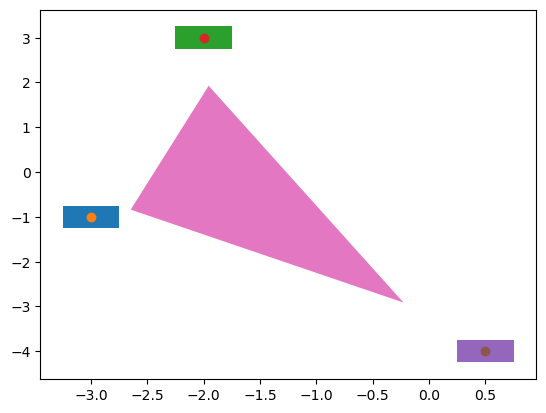

In [29]:
X = np.array([(-3,-1), (-2, 3),(0.5 ,-4)]);
imp = .25;
Bx = getPotRegions(X,imp);
safeX,safeY= calcsafepoint(3,Bx);
fig, ax = plt.subplots();
for i in range(3):
    xb = Bx[i][:,0];
    yb = Bx[i][:,1];
    ax.fill(xb,yb);
    x = X[i][0];
    y = X[i][1];
    ax.scatter(x,y);
ax.fill(safeX[0],safeY[0])

In [22]:
def getAllHulls(X,n,imp1,imp2):
        safepoints = [];
        x = X[n];
        X[n] = x+[imp1,0];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);
        X[n] = x+[-imp1,0];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);
        X[n] = x+[0, imp1];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);        
        X[n] = x+[0,-imp1];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);        
        X[n] = x+[imp1,imp1];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);        
        X[n] = x+[imp1,-imp1];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);        
        X[n] = x+[-imp1,imp1];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);        
        X[n] = x+[-imp1,-imp1];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);
        X[n] = x;
        return safepoints;
    

In [64]:
Bx = getPotRegions(X,imp2);
safeX,safeY = calcsafepoint(3,Bx);
safe = [np.mean(safeX),np.mean(safeY)];
print(safe)

[-1.8963414634146343, -0.14024390243902435]


In [40]:
testX = np.array([(0,0), (1,2),(3,0)]);
print(minOrthProj(testX(1),testX(2),testX));

TypeError: 'numpy.ndarray' object is not callable

In [21]:
print(safeX);

AttributeError: 'numpy.ndarray' object has no attribute 'type'

# CONSTANT IMPRECISION SIMULATION

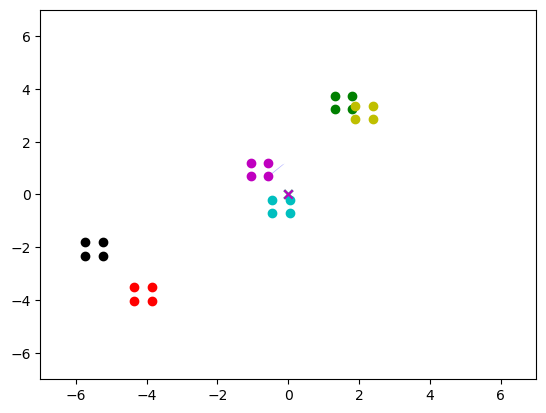

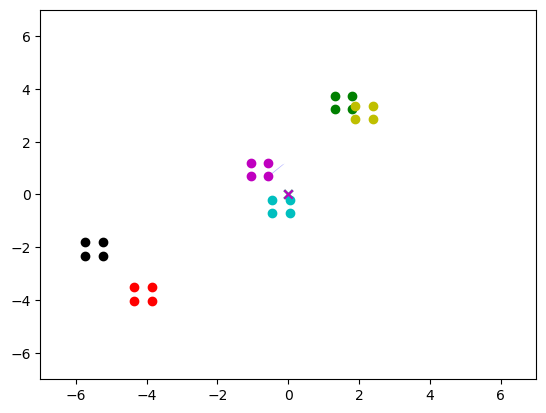

In [30]:
plt.ion();
fig, ax = plt.subplots()
#X = np.array([(-3,-1), (-2, 3),(0.5 ,-4),(1.5,6),(3.2,2),(4,-1)]);
offset = np.ones((6,2))*.5;
X= 12*(np.random.rand(6,2)-offset)
Xsave = X;
Xn = np.zeros((6,6,2));
Xn[:]= X;
n = len(X);
imp = .25;
colors= ['k','g','c','m','y','r'];
empty = False;
frames = [];
step = 0;
emptyCPIH = np.zeros((n,1));
target = np.zeros((n,2));
targetlast = np.zeros((n,2));
targetdist=np.zeros((n,1));
ims = [];
lastCPIH = [[],[],[],[],[]];
temp = [];
while not empty:
    im = [];
    #ax.cla();
    ax.set_xlim(-7,7);
    ax.set_ylim(-7,7);
    dt = .01;
    n = len(X);
    
    safeX= [];
    safeY=[];
    dist = 0;
    for i in range(n):
        Xn[i] = X+2*.25*(np.random.rand(6,2)-.5);
        Xn[i][i]  = X[i];
        if i!= n-1:
            Bx = getPotRegions(Xn[i],imp);

        #if i != n-1 and emptyCPIH[i] == 0:
        if i != n-1:
            safeX,safeY = CPIH_Safepoint(n,Bx);
            #CPIH = CPIH_Safepoint(n,Bx);
            #safeX,safeY = optConfig(Xn[i],i,imp);
            if (isinstance(safeX,int) and isinstance(safeY,int)):
                #print('CPIH empty');
                #empty = True;
                emptyCPIH[i] = 1;
                target[i] = targetlast[i]
            else:
                targetlast[i] = [np.mean(safeX),np.mean(safeY)]; 
                target[i],targetdist[i] = maxDist(X[i],safeX,safeY);
                lastCPIH[i] = [safeX,safeY];
               # emptyCPIH[i] =1;
            
        elif i== n-1:
            target[i] = np.array([(6,6)])
        
    for i in range(n):
        X[i]= X[i]+dt*(target[i]-X[i])/(np.linalg.norm(X[i]-target[i]))*max((np.linalg.norm(X[i]-target[i])),1);
        if i<n-1:
            dist += np.sqrt(np.dot((target[i]-X[i]),(target[i]-X[i])));
        #X[i]= X[i]+dt*(target[i]);
    if dist< (n-1)*imp*.5 or not any(emptyCPIH[0:4] == 0):
        empty = True;
    artist = ax.fill(safeX,safeY,'b',alpha = 0.3);
    
    for j in range(n):
            x = Bx[j,:,0];
            y = Bx[j,:,1];
            #ax.scatter(x,y)
            artist.append(ax.scatter(x,y,c= colors[j]));
            if emptyCPIH[j] == 1:
                artist.append(ax.scatter(target[j][0],target[j][1], c = colors[j],marker = 'x'))
    frames.append(artist);
    clear_output(wait = True);
   # fig.canvas.draw()
    #fig.canvas.flush_events();
    #display(fig);
    
    plt.pause(0.1)
    step +=1;
    
#ax.scatter(minimalhull[0],minimalhull[1]);


ani = animation.ArtistAnimation(fig= fig,artists = frames,interval = 50, blit = True);
ani.save('CPIH_rand_pos_t2.gif');
display(fig);

C:\Users\85chr\anaconda3\Lib\site-packages\shapely\set_operations.py:419: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
C:\Users\85chr\anaconda3\Lib\site-packages\shapely\set_operations.py:419: RuntimeWarning: divide by zero encountered in unary_union
  return lib.unary_union(collections, **kwargs)
C:\Users\85chr\anaconda3\Lib\site-packages\shapely\set_operations.py:131: RuntimeWarning: divide by zero encountered in intersection
  return lib.intersection(a, b, **kwargs)
C:\Users\85chr\anaconda3\Lib\site-packages\shapely\set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


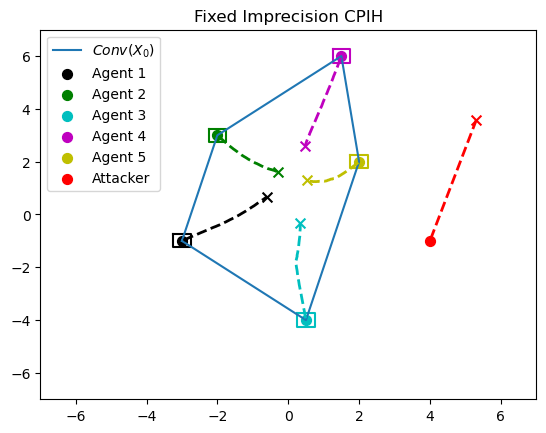

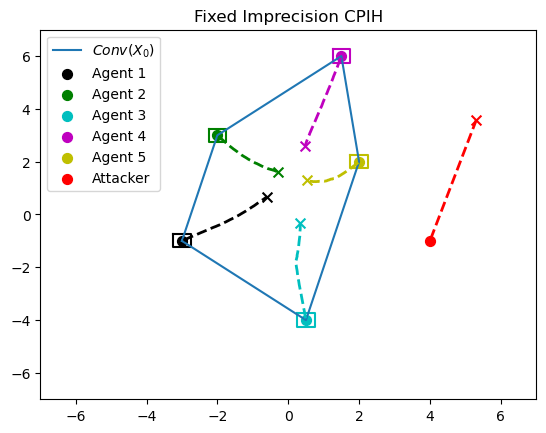

In [15]:

fig, ax = plt.subplots()
X = np.array([(-3,-1), (-2, 3),(0.5 ,-4),(1.5,6),(2,2),(4,-1)]);
offset = np.ones((6,2))*.5;
#X= 12*(np.random.rand(6,2)-offset)
#Xsave = X;
Xn = np.zeros((6,6,2));
Xhist = [];
Yhist = []


Xn[:]= X;
n = len(X);
imp = .25;
colors= ['k','g','c','m','y','r'];
empty = False;

step = 0;
emptyCPIH = np.zeros((n,1));
target = np.zeros((n,2));
targetlast = np.zeros((n,2));
targetdist=np.zeros((n,1));
ims = [];
lastCPIH = [[],[],[],[],[]];
temp = [];
#ax.plot(X[0:5,0],X[0:5,1]);
#ax.plot([X[4,0],X[0,0]],[X[4,1],X[0,1]]);
hull = ConvexHull(X[0:5]);
xplot = [];
yplot = [];
Bx = getPotRegions(X,imp);
for j in range(n-1):
            x = []; y = [];
            for k in range(4):
                x.append(Bx[j,k,0]);
                y.append(Bx[j,k,1]);
            x.append(Bx[j,0,0]);
            y.append(Bx[j,0,1]);
            #ax.scatter(x,y)
            ax.plot(x,y,c= colors[j]);
for v in hull.vertices:
    xplot.append(X[v,0]);
    yplot.append(X[v,1]);
xplot.append(X[hull.vertices[0],0]);
yplot.append(X[hull.vertices[0],1]);
ax.plot(xplot,yplot,label = r'$Conv(X_0)$');
for i in range(5):
    lbl = 'Agent '+str(i+1);
    ax.scatter(X[i,0],X[i,1],c= colors[i], marker = 'o',label = lbl,s =50);
ax.scatter(X[5,0],X[5,1],c= colors[5], marker = 'o',label = 'Attacker',s = 50);
while not empty:
    im = [];
    #ax.cla();
    ax.set_xlim(-7,7);
    ax.set_ylim(-7,7);
    dt = .01;
    n = len(X);
    
    safeX= [];
    safeY=[];
    dist = 0;
    for i in range(n):
        Xn[i] = X+2*.25*(np.random.rand(6,2)-.5);
        Xn[i][i]  = X[i];
        if i!= n-1:
            Bx = getPotRegions(Xn[i],imp);

        #if i != n-1 and emptyCPIH[i] == 0:
        if i != n-1:
            safeX,safeY = CPIH_Safepoint(n,Bx,i);
            #CPIH = CPIH_Safepoint(n,Bx);
            #safeX,safeY = optConfig(Xn[i],i,imp);
            if (isinstance(safeX,int) and isinstance(safeY,int)):
                #print('CPIH empty');
                #empty = True;
                emptyCPIH[i] = 1;
                target[i] = targetlast[i]
            else:
                targetlast[i] = [np.mean(safeX),np.mean(safeY)]; 
                target[i],targetdist[i] = maxDist(X[i],safeX,safeY);
                lastCPIH[i] = [safeX,safeY];
               # emptyCPIH[i] =1;
            
        elif i== n-1:
            target[i] = np.array([(6,6)])
    
    for i in range(n):
        X[i]= X[i]+dt*(target[i]-X[i])/(np.linalg.norm(X[i]-target[i]))*max((np.linalg.norm(X[i]-target[i])),1);
        if i<n-1:
            dist += np.sqrt(np.dot((target[i]-X[i]),(target[i]-X[i])));
        #X[i]= X[i]+dt*(target[i]);
    Xhist.append(X.copy());
    if dist< (n-1)*imp*.5 or not any(emptyCPIH[0:4] == 0):
        empty = True;
    #artist = ax.fill(safeX,safeY,'b',alpha = 0.3);
    
  
            #ax.scatter(x,y)
          
            #if emptyCPIH[j] == 1:
                #artist.append(ax.scatter(target[j][0],target[j][1], c = colors[j],marker = 'x'))
    
    #clear_output(wait = True);
   # fig.canvas.draw()
    #fig.canvas.flush_events();
    #display(fig);
    
    
    step +=1;
Bx = getPotRegions(Xhist[step-1],imp);
for i in range(6):
    xplot = ExtractX(Xhist,i);
    yplot = ExtractY(Xhist,i);
    endn = len(xplot);
    ax.plot(xplot,yplot,c = colors[i],linestyle='dashed',linewidth= 2);
    ax.scatter(xplot[endn-1],yplot[endn-1],c = colors[i], marker='x',s=50);


leg = ax.legend();
plt.title('Fixed Imprecision CPIH');
#ax.scatter(minimalhull[0],minimalhull[1]);
display(fig);
plt.savefig("ApproximateConsensus.jpg")

# VARIABLE IMPRECISION SIMULATION

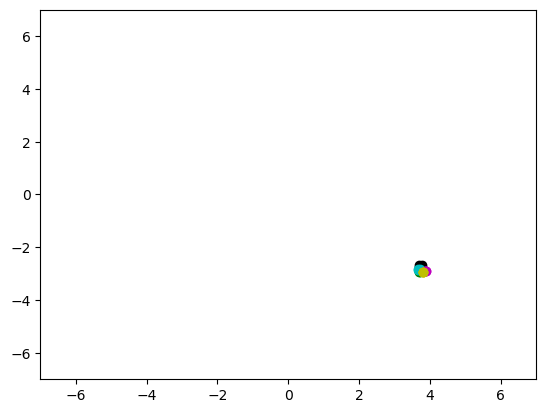

In [10]:
plt.ion();
fig, ax = plt.subplots()
X = np.array([(-3,-1), (-2, 3),(0.5 ,-4),(1.5,6),(1.2,2),(4,-1)]);
offset = np.ones((6,2))*.5;
X= 12*(np.random.rand(6,2)-offset)
Xn = np.zeros((6,6,2));
Xn[:]= X;
n = len(X);
imp = .5*np.ones((6,6))-.5*np.eye(6);
colors= ['k','g','c','m','y','r'];
empty = False;

frames = [];
step = 0;
emptyCPIH = np.zeros((6,1));
hist = [];
for i in range(5):
    hist.append([]);
B2hist = []
target = np.zeros((n,2));
targetdist=np.zeros((n,1));
ims = [];
while not empty:
    im = [];
    #ax.cla();
    ax.set_xlim(-7,7);
    ax.set_ylim(-7,7);
    dt = .01;
    n = len(X);
    
    safeX= [];
    safeY=[];
    dist = 0;
    for i in range(n):
        for j in range(n):
                mindist= minOrthProj(X[i],X[j],X);
                #imp[i][j] = np.linalg.norm(X[i]-X[j])/9;
                imp[i][j] = mindist/3;
                Xn[i][j] = X[j]+2*imp[i][j]*(np.random.rand(1,2)-.5);
        Xn[i][i]  = X[i];
        if i!= n-1:
            Bx = getPotRegions_var(Xn[i],imp[i][:]);

        #if i != n-1 and emptyCPIH[i] == 0:
        if i != n-1:
            safeX,safeY = CPIH_Safepoint(n,Bx,i);
            #CPIH = CPIH_Safepoint(n,Bx);
            #safeX,safeY = optConfig(Xn[i],i,imp);
            if (isinstance(safeX,int) and isinstance(safeY,int)):
                #print('CPIH empty');
                #empty = True;
                hist[i].append(-step);
                emptyCPIH[i] = 1;
                if i == 2:
                    B2hist.append(Bx);
                target[i]= X[i];
            else:
                #target[i] = [np.mean(safeX),np.mean(safeY)];
                target[i],targetdist[i] = maxDist(X[i],safeX,safeY);
                if emptyCPIH[i]:
                    hist[i].append(step);
                    emptyCPIH[i] = 0;
                    
               # emptyCPIH[i] =1;
            
        elif i== n-1:
            target[i] = np.array([(6,6)])
        
    for i in range(n-1):
        X[i]= X[i]+dt*targetdist[i]*(target[i]-X[i]);
        dist += np.sqrt(np.dot((target[i]-X[i]),(target[i]-X[i])));
        #X[i]= X[i]+dt*(target[i]);
    X[n-1] = X[n-1]+dt*target[n-1];
    if step>499 or any(emptyCPIH == 1):
        empty = True;
    artist = ax.fill(safeX,safeY,'b',alpha = 0.3);
    
    for j in range(n):
            x = Bx[j,:,0];
            y = Bx[j,:,1];
            #ax.scatter(x,y)
            artist.append(ax.scatter(x,y,c= colors[j]));
            if emptyCPIH[j] == 1:
                artist.append(ax.scatter(target[j][0],target[j][1], c = colors[j],marker = 'x'))
    frames.append(artist);
    clear_output(wait = True);
   # fig.canvas.draw()
    #fig.canvas.flush_events();
    #display(fig);
    
    plt.pause(0.1)
    step +=1;
    
#ax.scatter(minimalhull[0],minimalhull[1]);


ani = animation.ArtistAnimation(fig= fig,artists = frames,interval = 50, blit = True);
ani.save('CPIH.gif');
display(fig);

In [18]:
print(minplotvar1);

0.0


C:\Users\85chr\anaconda3\Lib\site-packages\shapely\set_operations.py:419: RuntimeWarning: divide by zero encountered in unary_union
  return lib.unary_union(collections, **kwargs)
C:\Users\85chr\anaconda3\Lib\site-packages\shapely\set_operations.py:419: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


4.123105625617661
0
2.7735009811261464
1
2.232625222605753
2
1.4552137502179983
3


C:\Users\85chr\anaconda3\Lib\site-packages\shapely\set_operations.py:131: RuntimeWarning: divide by zero encountered in intersection
  return lib.intersection(a, b, **kwargs)
C:\Users\85chr\anaconda3\Lib\site-packages\shapely\set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


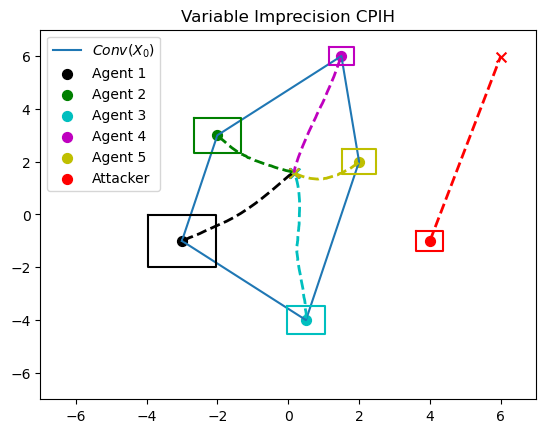

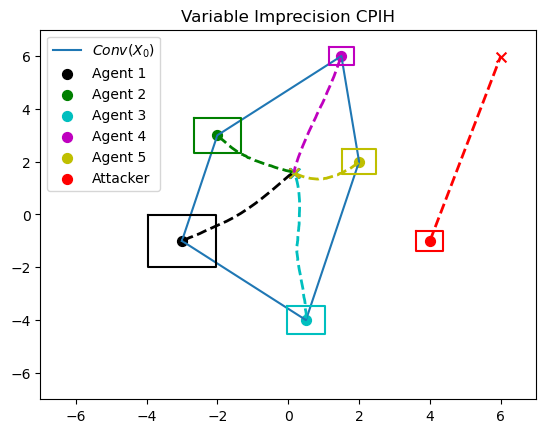

In [5]:

fig, ax = plt.subplots()
X = np.array([(-3,-1), (-2, 3),(0.5 ,-4),(1.5,6),(2,2),(4,-1)]);
offset = np.ones((6,2))*.5;
#X= 12*(np.random.rand(6,2)-offset)
Xn = np.zeros((6,6,2));
Xn[:]= X;
n = len(X);
imp = .5*np.ones((6,6))-.5*np.eye(6);
colors= ['k','g','c','m','y','r'];
empty = False;

frames = [];
step = 0;
emptyCPIH = np.zeros((6,1));
Xhist = [];
Yhist = [];
hull = ConvexHull(X[0:5]);
xplot = [];
yplot = [];

for v in hull.vertices:
    xplot.append(X[v,0]);
    yplot.append(X[v,1]);
xplot.append(X[hull.vertices[0],0]);
yplot.append(X[hull.vertices[0],1]);
ax.plot(xplot,yplot,label = r'$Conv(X_0)$');
for i in range(5):
    lbl = 'Agent '+str(i+1);
    ax.scatter(X[i,0],X[i,1],c= colors[i], marker = 'o',label = lbl,s =50);
ax.scatter(X[5,0],X[5,1],c= colors[5], marker = 'o',label = 'Attacker',s = 50);

target = np.zeros((n,2));
targetdist=np.zeros((n,1));

while not empty:
   
    #ax.cla();
   # ax.set_xlim(-7,7);
   # ax.set_ylim(-7,7);
    dt = .01;
    n = len(X);
    
    safeX= [];
    safeY=[];
    dist = 0;
    for i in range(n):
        for j in range(n):
                mindist= minOrthProj(X[i],X[j],X);
                #imp[i][j] = np.linalg.norm(X[i]-X[j])/9;
                imp[i][j] = mindist/(np.sqrt(2)*3);
                Xn[i][j] = X[j]+2*imp[i][j]*(np.random.rand(1,2)-.5);
        Xn[i][i]  = X[i];
        if i!= n-1:
            Bx = getPotRegions_var(Xn[i],imp[i][:]);
        if step == 0 and i == n-2:          
                minplotvar1 =100;
                for l in range(n):
                    if l != 4:
                        plotvar1 = minOrthProj(X[n-2],X[l],X);
                    if plotvar1< minplotvar1:
                        print(plotvar1);
                        print(l);
                        minplotvar1 = plotvar1;
                impplot = imp.copy();
                impplot[n-2][n-2] =  minplotvar1/3;
                Bxplot = getPotRegions_var(X,impplot[n-2][:])    
                
                for l in range(n):
                    x = []; y = [];
                    for k in range(4):
                        x.append(Bxplot[l,k,0]);
                        y.append(Bxplot[l,k,1]);
                    x.append(Bxplot[l,0,0]);
                    y.append(Bxplot[l,0,1]);
                    ax.plot(x,y,c= colors[l]);
        #if i != n-1 and emptyCPIH[i] == 0:
        if i != n-1:
            safeX,safeY = CPIH_Safepoint(n,Bx,i);
            #CPIH = CPIH_Safepoint(n,Bx);
            #safeX,safeY = optConfig(Xn[i],i,imp);
            if (isinstance(safeX,int) and isinstance(safeY,int)):
                #print('CPIH empty');
                #empty = True;
                hist[i].append(-step);
                emptyCPIH[i] = 1;
                if i == 2:
                    B2hist.append(Bx);
                target[i]= X[i];
            else:
                #target[i] = [np.mean(safeX),np.mean(safeY)];
                target[i],targetdist[i] = maxDist(X[i],safeX,safeY);
                
                if emptyCPIH[i]:
                    hist[i].append(step);
                    emptyCPIH[i] = 0;
                    
               # emptyCPIH[i] =1;
            
        elif i== n-1:
            target[i] = np.array([(6,6)])
       
                
        
    for i in range(n-1):
        #X[i]= X[i]+dt*targetdist[i]*(target[i]-X[i]);
        X[i]= X[i]+dt*(target[i]-X[i]);

        #X[i]= X[i]+dt*(target[i]);
    Xhist.append(X.copy());
    X[n-1] = X[n-1]+dt*(target[n-1]-X[n-1]);
    
    
    if step>600 or any(emptyCPIH == 1):
        empty = True;
   # fig.canvas.draw()
    #fig.canvas.flush_events();
    #display(fig);
    step +=1;
    
#ax.scatter(minimalhull[0],minimalhull[1]);

for i in range(6):
    xplot = ExtractX(Xhist,i);
    yplot = ExtractY(Xhist,i);
    endn = len(xplot);
    ax.plot(xplot,yplot,c = colors[i],linestyle='dashed',linewidth= 2);
    ax.scatter(xplot[endn-1],yplot[endn-1],c = colors[i], marker='x',s=50);
ax.set_xlim(-7,7);
ax.set_ylim(-7,7);

leg = ax.legend();
plt.title('Variable Imprecision CPIH');
#ax.scatter(minimalhull[0],minimalhull[1]);
display(fig);
plt.savefig("VariableImprecision.jpg")

In [26]:
print(x)

[1.2, 1.2, 1.2, 1.2, 1.2]


# Live Simulation

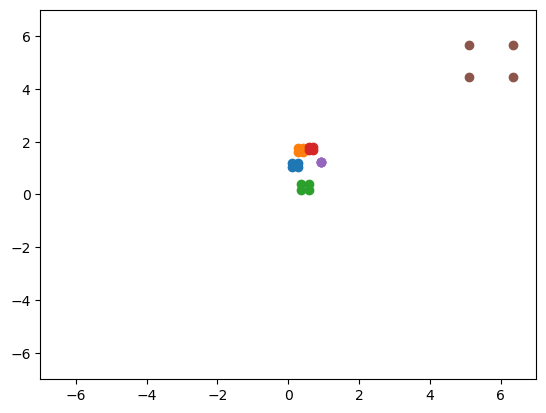

In [13]:
plt.ion();
fig, ax = plt.subplots();
X = np.array([(-3,-1), (-2, 3),(0.5 ,-4),(1.5,6),(3.2,2),(4,-1)]);
Xn = np.zeros((6,6,2));
Xn[:]= X;
imp = .5*np.ones((6,6))-.5*np.eye(6);

#plt.ion();
plot1 = [];
plot2 = [];

for t in range(200):
    ax.cla();
    ax.set_xlim(-7,7);
    ax.set_ylim(-7,7);
    dx = .01;
    n = len(X);
    target = np.zeros((n,2));
    for i in range(n):
        if i != n-1:
            for j in range(n):
                imp[i][j] = np.linalg.norm(X[i]-X[j])/10;
            #Xn[i] = X+2*imp*(np.random.rand(6,2)-.5);
            Bx = getPotRegions_var(X,imp[i][:]);
            safeX,safeY = CPIH_Safepoint(n,Bx);
            target[i] = [np.mean(safeX),np.mean(safeY)]; 
            
        else:
            target[i] = np.array([(6,6)])
        
    for i in range(n):
        X[i]= X[i]+dx*(target[i]-X[i]);
        

    #ax,plot1,plot2 = plotagents(fig,Bx,safeX,safeY,ax,t,plot1,plot2);
    
   # for i in range(len(safeX)):
    #        x = safeX[i][:];
     #       y = safeY[i][:];
      #      ax.fill(x,y);
    for j in range(n):
            x = Bx[j,:,0];
            y = Bx[j,:,1];
            ax.scatter(x,y);
    fig.canvas.draw()
    fig.canvas.flush_events();
    display(fig);
    clear_output(wait = True);
    plt.pause(0.1)

    

In [13]:
hist = [];
for i in range(5):
    hist.append([]);
hist[1].append(3);
hist[1].append(4);
print(hist)
    

[[], [3, 4], [], [], []]


In [24]:
print(emptyCPIH)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [36]:
print(hist[4][:])

[]


In [14]:
print(B2hist[0][:])

IndexError: list index out of range

IndexError: list index out of range

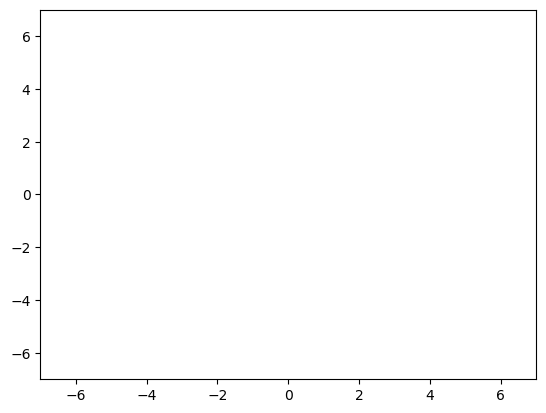

In [15]:
fig, ax = plt.subplots();
ax.cla();
ax.set_xlim(-7,7);
ax.set_ylim(-7,7);
for i in range(len(B2hist[0][:])):
    x = B2hist[0][i][:,0];
    y = B2hist[0][i][:,1];
    ax.scatter(x,y)
sx,sy = CPIH_Safepoint(n,B2hist[0][:]);
ax.fill(sx,sy)
#       y = safeY[i][:];
      #      ax.fill(x,y);

In [30]:
sx,sy = CPIH_Safepoint(n,B2hist[0][:]);

In [30]:
print(dist/5)

0.2690806449515544


In [31]:
print(step)

501
